In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from nilearn.plotting import plot_stat_map
from nilearn.image import new_img_like
import pymc3 as pm
import pickle
from nipymc.plotting import plot_wholebrain_test_stat
from nipymc.data import EmotionTaskFactory
from nipymc.model import BayesianModel
from glob import glob
import os
from os.path import join

In [ ]:
'''
Important note: reading in these four saved model objects requires installing
the 2016-09-01 version of PyMC3 (not the most recent version). This is pretty
easy to do using git, but it does require cloning the pymc3 repository.
First uninstall pymc3 using:

    pip uninstall pymc3

Now navigate to the local directory where you want the pymc3 clone to be located.
From there use the commands:

    git clone https://github.com/pymc-devs/pymc3.git
    cd pymc3
    git checkout `git rev-list -n 1 --before="2016-09-01 00:00" master`
    python setup.py install

Make sure to restart your Python kernel, and now you should be able to run the
following code box that reads in the fitted model objects.
'''

In [3]:
# load saved models
with pm.Model():
    emo2_fitted = pickle.load(open('../results/emo_results/emo_fix_amygdala_fitted.pkl', 'rb'))
    emo3_fitted = pickle.load(open('../results/emo_results/emo_rand_amygdala_fitted.pkl', 'rb'))
    lang_fix_r10_trace = pickle.load(open('../results/lang_results/lang_fix_r10_trace.pkl', 'rb'))
    lang_rand_r10_trace = pickle.load(open('../results/lang_results/lang_rand_r10_trace.pkl', 'rb'))

# Figure 2

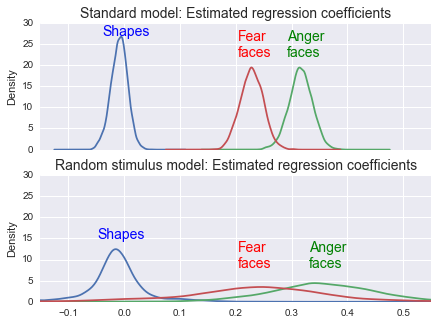

In [6]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=[7,5])
fs = 14 # font size
burn = 1000
means = np.vstack([emo2_fitted.trace['b_emotion'][burn:].mean(0),
                   emo3_fitted.trace['b_emotion'][burn:].mean(0)])

pd.DataFrame(emo2_fitted.trace['b_emotion'][burn:]).plot.kde(legend=False, ax=axes[0])
axes[0].set_title('Standard model: Estimated regression coefficients', fontsize=fs)
axes[0].text(x=means[0,0]-.03, y=27, s='Shapes', color='blue', fontsize=fs)
axes[0].text(x=means[0,2]-.025, y=22, s='Fear\nfaces', color='red', fontsize=fs)
axes[0].text(x=means[0,1]-.025, y=22, s='Anger\nfaces', color='green', fontsize=fs)
pd.DataFrame(emo3_fitted.trace['b_emotion'][burn:]).plot.kde(legend=False, ax=axes[1])
axes[1].set_title('Random stimulus model: Estimated regression coefficients', fontsize=fs)
axes[1].text(x=means[1,0]-.03, y=15, s='Shapes', color='blue', fontsize=fs)
axes[1].text(x=means[1,2]-.025, y=8, s='Fear\nfaces', color='red', fontsize=fs)
axes[1].text(x=means[1,1]-.025, y=8, s='Anger\nfaces', color='green', fontsize=fs)
plt.xlim(-.15, .55)
plt.savefig('figure2.png', dpi=300)

# Figure 3

In [10]:
# grab and compute various objects needed for the plot

# matrices of subject effects and item effects
sub_mat = np.vstack([
    np.vstack([emo2_fitted.trace['u_subject_0'].mean(0) + emo2_fitted.trace['b_emotion'][:,0].mean()]*3),
    np.vstack([emo2_fitted.trace['u_subject_1'].mean(0) + emo2_fitted.trace['b_emotion'][:,1].mean()]*10),
    np.vstack([emo2_fitted.trace['u_subject_-1'].mean(0) + emo2_fitted.trace['b_emotion'][:,2].mean()]*10)])
item_effects = np.vstack([np.hstack([
    emo3_fitted.trace['u_stimulus_0'].mean(0),
    emo3_fitted.trace['u_stimulus_1'].mean(0),
    emo3_fitted.trace['u_stimulus_-1'].mean(0)])]*111)
sub_mat_emo3 = np.vstack([
    np.vstack([emo3_fitted.trace['u_subject_0'].mean(0) + emo3_fitted.trace['b_emotion'][:,0].mean()]*3),
    np.vstack([emo3_fitted.trace['u_subject_1'].mean(0) + emo3_fitted.trace['b_emotion'][:,1].mean()]*10),
    np.vstack([emo3_fitted.trace['u_subject_-1'].mean(0) + emo3_fitted.trace['b_emotion'][:,2].mean()]*10)])

# get the mapping between unique stimuli and their indices
factory = EmotionTaskFactory('../data')
dataset = factory.get_dataset(discard_vols=5)
test_mod = BayesianModel(dataset)
test_mod.add_term(['left_stim','right_stim'], label='stimulus',
    split_by='emotion',random=True, categorical=True)
levels = test_mod.level_map

# build a DataFrame containing the map between face #s and image filenames
stim_key = [['MF3_top', 'MF3_left'],['MF3_right'],['MF2_top', 'MF2_right'],
            ['MF2_left', 'MF1_top', 'MF1_left'],['MF1_right'],
            ['MA3_top', 'MA3_left', 'MA1_left'],['MA3_right'],['MA2_top', 'MA2_right'],
            ['MA2_left'],['MA1_top', 'MA1_right'],['FF3_top', 'FF3_right'],['FF3_left'],
            ['FF2_top', 'FF2_left'],['FF2_right', 'FF1_top', 'FF1_right'],['FF1_left'],
            ['FA3_top', 'FA3_left'],['FA3_right'],['FA2_top', 'FA2_right'],
            ['FA2_left', 'FA1_top', 'FA1_left'],['FA1_right']]
stim_key = dict(zip(['face'+str(x) for x in range(20)], stim_key))
faces = [x for x in levels['u_stimulus_1'].keys()] + [x for x in levels['u_stimulus_-1'].keys()]
stim_key = pd.DataFrame(np.vstack([
    faces,
    pd.Series(faces).replace(stim_key)])).T

# faces sorted by their random effects
anger = stim_key.iloc[np.argsort(emo3_fitted.trace['u_stimulus_1'].mean(0)),:]
anger_imgs = [mpimg.imread('../data/stimuli/emotion_stims/'+x+'.png') for x in anger.iloc[:,1]]
fear = stim_key.iloc[np.argsort(emo3_fitted.trace['u_stimulus_-1'].mean(0))+10,:]
fear_imgs = [mpimg.imread('../data/stimuli/emotion_stims/'+x+'.png') for x in fear.iloc[:,1]]
anger_effects = np.sort(emo3_fitted.trace['u_stimulus_1'].mean(0))
fear_effects = np.sort(emo3_fitted.trace['u_stimulus_-1'].mean(0))

/Users/Jake/Desktop/Google Drive/nipymc/nipymc/data.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.design_data['emotion'][top_stim.str.get(1) == 'A'] = 1
/Users/Jake/Desktop/Google Drive/nipymc/nipymc/data.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.design_data['emotion'][top_stim.str.get(1) == 'F'] = -1
/Users/Jake/Desktop/Google Drive/nipymc/nipymc/data.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-co

Applied log-transform to sigma_stimulus_0 and added transformed sigma_stimulus_0_log_ to model.
Applied log-transform to sigma_stimulus_1 and added transformed sigma_stimulus_1_log_ to model.
Applied log-transform to sigma_stimulus_-1 and added transformed sigma_stimulus_-1_log_ to model.


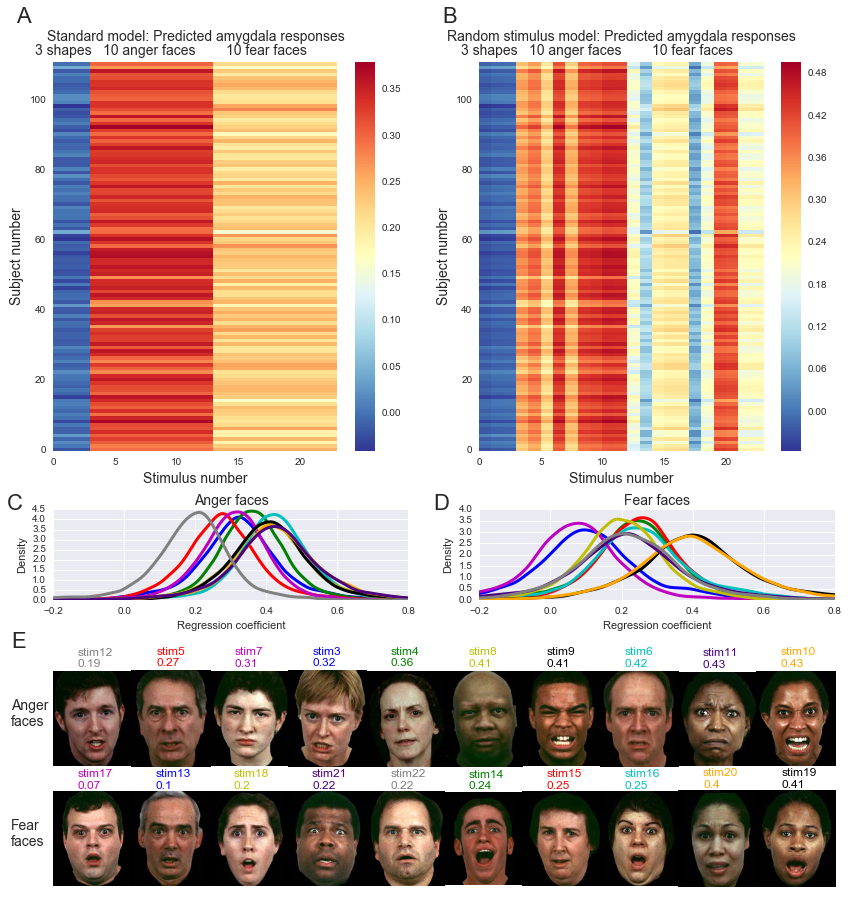

In [12]:
# specify size and layout of plot
fig = plt.figure(figsize=(14, 15)) 
gs0 = GridSpec(6, 1, hspace=.65)
gs00 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[:3])
gs01 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[3])
gs02 = GridSpecFromSubplotSpec(2, 10, subplot_spec=gs0[4:6], wspace=0, hspace=0)
fs = 14 # font size
col = ['b','g','r','c','m','y','k','orange','indigo','gray']
burn = 1000

# matrix plots
titles = ['Standard model: Predicted amygdala responses\n',
         'Random stimulus model: Predicted amygdala responses\n']
dat = [sub_mat.T, sub_mat_emo3.T + item_effects]
for i in range(2):
    _ax = plt.subplot(gs00[:, i])
    _mesh = _ax.pcolor(dat[i], cmap='RdYlBu_r')
    _ax.set_title(titles[i], fontsize=fs)
    _ax.set_xlabel('Stimulus number', fontsize=fs)
    _ax.set_ylabel('Subject number', fontsize=fs)
    _ax.text(x=-1.5, y=113, s='3 shapes', fontsize=fs)
    _ax.text(x=4, y=113, s='10 anger faces', fontsize=fs)
    _ax.text(x=14, y=113, s='10 fear faces', fontsize=fs)
    plt.colorbar(_mesh, ax=_ax)
    plt.xlim(0, 23)
    plt.ylim(0, 111)

    
# stimulus density plots
ax10 = plt.subplot(gs01[:, 0])
pd.DataFrame(emo3_fitted.trace['u_stimulus_1'][burn:]+
             emo3_fitted.trace['b_emotion'][burn:, 1].mean()
            ).plot.kde(legend=False, ax=ax10, linewidth=3, color=col)
ax10.set_title('Anger faces', fontsize=fs)
ax10.set_xlabel('Regression coefficient')
plt.xlim(-.2, .8)
ax11 = plt.subplot(gs01[:, 1])
pd.DataFrame(emo3_fitted.trace['u_stimulus_-1'][burn:]+
             emo3_fitted.trace['b_emotion'][burn:, 2].mean()
            ).plot.kde(legend=False, ax=ax11, linewidth=3, color=col)
ax11.set_title('Fear faces', fontsize=fs)
ax11.set_xlabel('Regression coefficient')
plt.xlim(-.2, .8)

# face images
for anger_img in range(10):
    _ax = plt.subplot(gs02[0, anger_img])
    if anger_img==0: _ax.text(x=-70, y=90, s='Anger\nfaces', fontsize=fs)
    _ax.imshow(anger_imgs[anger_img])
    _ax.axis('off')
    _ax.text(x=40, y=-8, s='stim'+str(levels['u_stimulus_1'][anger.iloc[anger_img,0]]+3)+'\n'+
        str(np.round(anger_effects[anger_img]+emo3_fitted.trace['b_emotion'][:,1].mean(),2)),
        fontsize=fs-2, color=dict(zip(levels['u_stimulus_1'].keys(),col))[anger.iloc[anger_img,0]])
for fear_img in range(10):
    _ax = plt.subplot(gs02[1, fear_img])
    if fear_img==0: _ax.text(x=-70, y=90, s='Fear\nfaces', fontsize=fs)
    _ax.imshow(fear_imgs[fear_img])
    _ax.axis('off')
    _ax.text(x=40, y=-5, s='stim'+str(levels['u_stimulus_-1'][fear.iloc[fear_img,0]]+13)+'\n'+
        str(np.round(fear_effects[fear_img]+emo3_fitted.trace['b_emotion'][:,2].mean(),2)),
        fontsize=fs-2, color=dict(zip(levels['u_stimulus_-1'].keys(),col))[fear.iloc[fear_img,0]])
    
# label plots
plt.subplot(gs00[:, 0]).text(x=-3, y=122, s="A", fontsize=22)
plt.subplot(gs00[:, 1]).text(x=-3, y=122, s="B", fontsize=22)
plt.subplot(gs01[0, 0]).text(x=-.33, y=4.5, s="C", fontsize=22)
plt.subplot(gs01[0, 1]).text(x=-.33, y=4, s="D", fontsize=22)
plt.subplot(gs02[0, 0]).text(x=-70, y=-40, s="E", fontsize=22)
plt.savefig('figure3.png', dpi=300)

# Figure 4: scatterplots and brains

//anaconda/envs/python3/lib/python3.5/site-packages/nilearn/plotting/displays.py:577: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


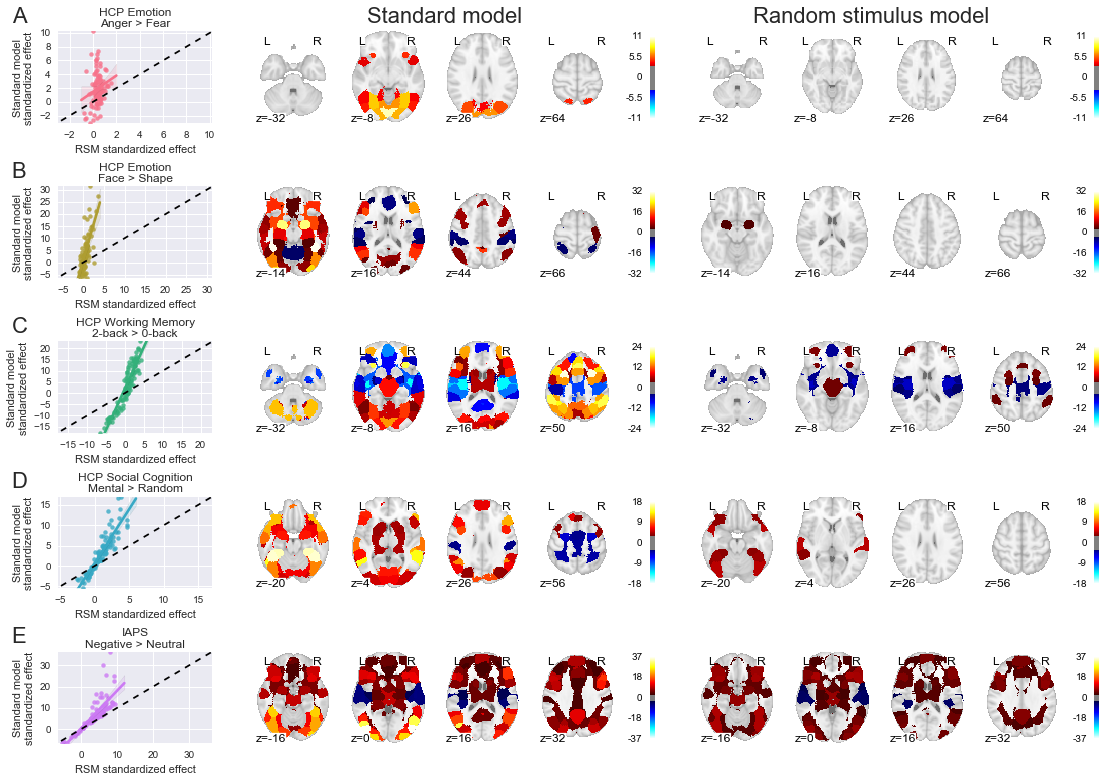

In [17]:
# Elements of each tuple are (dir_name, contrast_name, title, max_region, 
# invert_image, cut_coords)
contrasts = [
    ('emo', 'angerVsFear', 'HCP Emotion\nAnger > Fear', 100, 0, 4),
    ('emo', 'faceVsShape', 'HCP Emotion\nFace > Shape', 100, 1, 4),
    ('wm', '0back_vs_2back', 'HCP Working Memory\n2-back > 0-back', 100, 0, 4),
    ('sc', 'randomVsMental', 'HCP Social Cognition\nMental > Random', 100, 0, 4),
    ('iaps', 'b_Valence', 'IAPS\nNegative > Neutral', 100, 1, [-16, 0, 16, 32]),
#     ('reg', 'neg_vs_neut', 'Emotion regulation\nNegative > Neutral', 99, 1, [-16, 0, 16, 32]),
#     ('reg', 'suppr_vs_att', 'Emotion regulation\nSuppress > Attend', 99, 0, 4),
#     ('lang', 'storyVsMath', 'HCP Language\nStory > Math', 100, 1, 4),
]

n_r = len(contrasts)
fig = plt.figure(figsize=(22*.85, n_r*3*.85))
grid = GridSpec(n_r, 3, width_ratios=(1.5, 4, 4), hspace=0.7, wspace=.1)
colors = sns.color_palette('husl', n_r)

for i in range(n_r):
    
    try:
    
        # Scatter plot of standard vs. RSM z-statistics
        scatter_ax = plt.subplot(grid[i, 0])
        name, contrast, label, max_r, invert, cc = contrasts[i]

        filename = join('../results', name + '_results', name + '_fix_r%s_summary.pkl')
        fixed = np.array([pickle.load(open(filename % r, 'rb'))['terms'][contrast]['z']
                for r in range(1, 1 + max_r)]).ravel()
        if invert:
            fixed *= -1
        fixed_img = plot_wholebrain_test_stat(filename % '*',
                           '../data/masks/whole_brain_cluster_labels_PCA=100_k=100.nii.gz',
                           name=contrast, invert=invert, plot=False, type='term')

        filename = join('../results', name + '_results', name + '_rand_r%s_summary.pkl')
        rand = np.array([pickle.load(open(filename % r, 'rb'))['terms'][contrast]['z']
                for r in range(1, 1 + max_r)]).ravel()
        if invert:
            rand *= -1
        rand_img = plot_wholebrain_test_stat(filename % '*',
                       '../data/masks/whole_brain_cluster_labels_PCA=100_k=100.nii.gz',
                       name=contrast, invert=invert, plot=False, type='term')

        sns.regplot(y=fixed, x=rand, ax=scatter_ax, color=colors[i])
        scatter_ax.set_autoscale_on(False)
        bounds = [np.min(fixed), np.max(fixed)]
        scatter_ax.set_xlim(bounds)
        scatter_ax.set_ylim(bounds)
        scatter_ax.set_xlabel('RSM standardized effect')
        scatter_ax.set_ylabel('Standard model\nstandardized effect')
        scatter_ax.set_title(label)
        scatter_ax.plot([-100, 100], [-100, 100], linestyle='dashed', color='k')

        # Plot RSM map first to make sure we display any regions that have non-zero values.
        # If we plot standard map first, odds are high that we miss showing regions that
        # survive correction in the RSM map.
        vmax = np.ceil(np.abs(fixed_img.get_data()).max())
        
        rand_ax = plt.subplot(grid[i, 2])
        p = plot_stat_map(rand_img, vmax=vmax, colorbar=True,
              cut_coords=cc, display_mode='z', threshold=3.3, axes=rand_ax)
        
        fixed_ax = plt.subplot(grid[i, 1])
        plot_stat_map(fixed_img, vmax=vmax, colorbar=True,
                  cut_coords=p.cut_coords, display_mode='z', threshold=3.3, axes=fixed_ax)
        
    
    except:
        import traceback
        print(traceback.format_exc())

# add subplot labels
lim = [plt.subplot(grid[i, 0]).get_xlim() for i in range(n_r)]
plt.subplot(grid[0, 0]).text(x=lim[0][1] + 1*(lim[0][1]-lim[0][0]),
                             y=lim[0][1] + .1*(lim[0][1]-lim[0][0]),
                             s="Standard model", fontsize=22)
plt.subplot(grid[0, 0]).text(x=lim[0][1] + 3.5*(lim[0][1]-lim[0][0]),
                             y=lim[0][1] + .1*(lim[0][1]-lim[0][0]),
                             s="Random stimulus model", fontsize=22)
for i,x in enumerate(['A','B','C','D','E']):
    plt.subplot(grid[i, 0]).text(x=lim[i][0] - .3*(lim[i][1]-lim[i][0]),
                                 y=lim[i][1] + .1*(lim[i][1]-lim[i][0]),
                                 s=x, fontsize=22)

plt.savefig('figure4.png', dpi=300)

# Figure 5

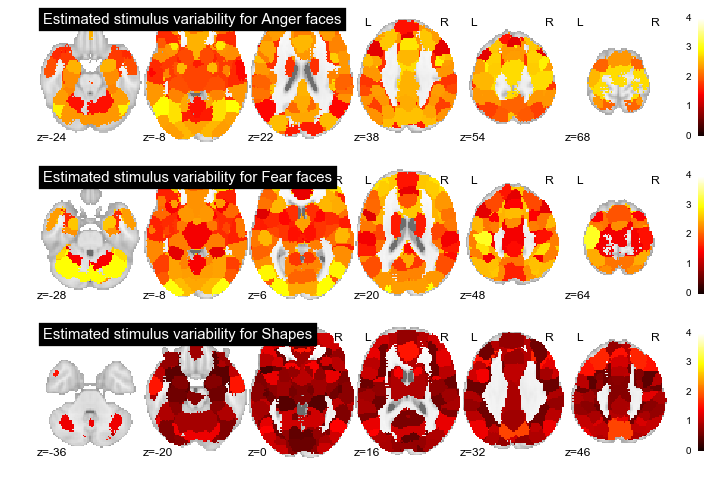

In [14]:
name = 'sigma_stimulus_0'
shape_var = plot_wholebrain_test_stat('../results/emo_results/emo_rand_r*_summary.pkl',
                   '../data/masks/whole_brain_cluster_labels_PCA=100_k=100.nii.gz',
                   name=name, invert=0, plot=False, type='term')

name = 'sigma_stimulus_-1'
fear_var = plot_wholebrain_test_stat('../results/emo_results/emo_rand_r*_summary.pkl',
                   '../data/masks/whole_brain_cluster_labels_PCA=100_k=100.nii.gz',
                   name=name, invert=0, plot=False, type='term')

name = 'sigma_stimulus_1'
anger_var = plot_wholebrain_test_stat('../results/emo_results/emo_rand_r*_summary.pkl',
                   '../data/masks/whole_brain_cluster_labels_PCA=100_k=100.nii.gz',
                   name=name, invert=0, plot=False, type='term')

cc = 6
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
vmax = np.ceil(np.abs(fear_var.get_data()).max())

plot_stat_map(anger_var, title='Estimated stimulus variability for Anger faces', vmax=vmax,
              cut_coords=cc, display_mode='z', axes=axes[0], threshold=0.01)
plot_stat_map(fear_var, title='Estimated stimulus variability for Fear faces', vmax=vmax,
              cut_coords=cc, display_mode='z', axes=axes[1], threshold=0.01)
plot_stat_map(shape_var, title='Estimated stimulus variability for Shapes', vmax=vmax,
              cut_coords=cc, display_mode='z', axes=axes[2], threshold=0.01)

plt.savefig('figure5.png', dpi=300)

# Figure 6

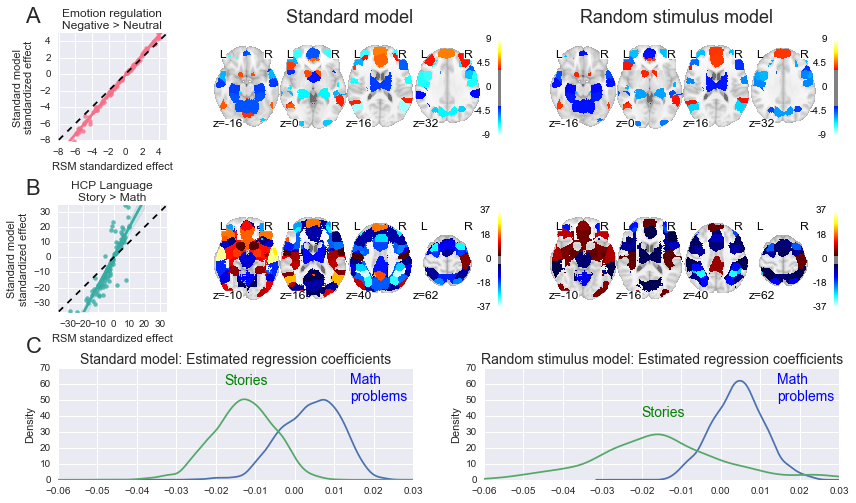

In [16]:
# Elements of each tuple are (dir_name, contrast_name, title, max_region, 
# invert_image, cut_coords)
contrasts = [
#     ('emo', 'angerVsFear', 'HCP Emotion\nAnger > Fear', 100, 0, 4),
#     ('emo', 'faceVsShape', 'HCP Emotion\nFace > Shape', 100, 1, 4),
#     ('wm', '0back_vs_2back', 'HCP Working Memory\n2-back > 0-back', 100, 0, 4),
#     ('sc', 'randomVsMental', 'HCP Social Cognition\nMental > Random', 100, 0, 4),
#     ('iaps', 'b_Valence', 'IAPS\nNegative > Neutral', 100, 1, [-16, 0, 16, 32]),
    ('reg', 'neg_vs_neut', 'Emotion regulation\nNegative > Neutral', 99, 1, [-16, 0, 16, 32]),
#     ('reg', 'suppr_vs_att', 'Emotion regulation\nSuppress > Attend', 99, 0, 4),
    ('lang', 'storyVsMath', 'HCP Language\nStory > Math', 100, 1, 4),
]

n_r = len(contrasts)
colors = sns.color_palette('husl', n_r)

# specify size and layout of plot
fig = plt.figure(figsize=(14, 8)) 
gs0 = GridSpec(n_r+1, 1, hspace=0.5)
gs00 = GridSpecFromSubplotSpec(n_r, 3, width_ratios=(1.5, 4, 4), hspace=.6, subplot_spec=gs0[:n_r])
gs01 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[2])
colors = sns.color_palette('husl', n_r)


# First panel: Standardized effect scatter plots & brain maps


for i in range(n_r):
    
    try:
    
        # Scatter plot of standard vs. RSM z-statistics
        scatter_ax = plt.subplot(gs00[i, 0])
        name, contrast, label, max_r, invert, cc = contrasts[i]

        filename = join('../results', name + '_results', name + '_fix_r%s_summary.pkl')
        fixed = np.array([pickle.load(open(filename % r, 'rb'))['terms'][contrast]['z']
                for r in range(1, 1 + max_r)]).ravel()
        if invert:
            fixed *= -1
        fixed_img = plot_wholebrain_test_stat(filename % '*',
                           '../data/masks/whole_brain_cluster_labels_PCA=100_k=100.nii.gz',
                           name=contrast, invert=invert, plot=False, type='term')

        filename = join('../results', name + '_results', name + '_rand_r%s_summary.pkl')
        rand = np.array([pickle.load(open(filename % r, 'rb'))['terms'][contrast]['z']
                for r in range(1, 1 + max_r)]).ravel()
        if invert:
            rand *= -1
        rand_img = plot_wholebrain_test_stat(filename % '*',
                       '../data/masks/whole_brain_cluster_labels_PCA=100_k=100.nii.gz',
                       name=contrast, invert=invert, plot=False, type='term')

        sns.regplot(y=fixed, x=rand, ax=scatter_ax, color=colors[i])
        scatter_ax.set_autoscale_on(False)
        bounds = [np.min(fixed), np.max(fixed)]
        scatter_ax.set_xlim(bounds)
        scatter_ax.set_ylim(bounds)
        scatter_ax.set_xlabel('RSM standardized effect')
        scatter_ax.set_ylabel('Standard model\nstandardized effect')
        scatter_ax.set_title(label)
        scatter_ax.plot([-100, 100], [-100, 100], linestyle='dashed', color='k')

        # Plot RSM map first to make sure we display any regions that have non-zero values.
        # If we plot standard map first, odds are high that we miss showing regions that
        # survive correction in the RSM map.
        vmax = np.ceil(np.abs(fixed_img.get_data()).max())
        
        rand_ax = plt.subplot(gs00[i, 2])
        p = plot_stat_map(rand_img, vmax=vmax, colorbar=True,
              cut_coords=cc, display_mode='z', threshold=3.3, axes=rand_ax)
        
        fixed_ax = plt.subplot(gs00[i, 1])
        plot_stat_map(fixed_img, vmax=vmax, colorbar=True,
                  cut_coords=p.cut_coords, display_mode='z', threshold=3.3, axes=fixed_ax)
        
    except:
        import traceback
        print(traceback.format_exc())

        
# Second panel: Posterior density plots for Math and Story conditions


fs = 14 # font size
burn = 100
means = np.vstack([lang_fix_r10_trace['b_condition'][burn:].mean(0),
                   lang_rand_r10_trace['b_condition'][burn:].mean(0)])

ax0 = plt.subplot(gs01[:, 0])
pd.DataFrame(lang_fix_r10_trace['b_condition'][burn:]).plot.kde(legend=False, ax=ax0)
ax0.set_title('Standard model: Estimated regression coefficients', fontsize=fs)
ax0.text(x=means[0,0]+.01, y=50, s='Math\nproblems', color='blue', fontsize=fs)
ax0.text(x=means[0,1]-.005, y=60, s='Stories', color='green', fontsize=fs)
plt.xlim(-.06, .03)
plt.ylim(0, 70)

ax1 = plt.subplot(gs01[:, 1])
pd.DataFrame(lang_rand_r10_trace['b_condition'][burn:]).plot.kde(legend=False, ax=ax1)
ax1.set_title('Random stimulus model: Estimated regression coefficients', fontsize=fs)
ax1.text(x=means[1,0]+.01, y=50, s='Math\nproblems', color='blue', fontsize=fs)
ax1.text(x=means[1,1]-.005, y=40, s='Stories', color='green', fontsize=fs)
plt.xlim(-.06, .03)
plt.ylim(0, 70)

# label plots
lim = [plt.subplot(gs00[i, 0]).get_xlim() for i in range(n_r)]
plt.subplot(gs00[0, 0]).text(x=lim[0][0] - .3*(lim[0][1]-lim[0][0]),
                             y=lim[0][1] + .1*(lim[0][1]-lim[0][0]),
                             s="A", fontsize=22)
plt.subplot(gs00[0, 0]).text(x=lim[0][1] + 1.1*(lim[0][1]-lim[0][0]),
                             y=lim[0][1] + .1*(lim[0][1]-lim[0][0]),
                             s="Standard model", fontsize=18)
plt.subplot(gs00[0, 0]).text(x=lim[0][1] + 3.8*(lim[0][1]-lim[0][0]),
                             y=lim[0][1] + .1*(lim[0][1]-lim[0][0]),
                             s="Random stimulus model", fontsize=18)
plt.subplot(gs00[1, 0]).text(x=lim[1][0] - .3*(lim[1][1]-lim[1][0]),
                             y=lim[1][1] + .1*(lim[1][1]-lim[1][0]),
                             s="B", fontsize=22)
plt.subplot(gs01[0, 0]).text(x=-.068, y=80, s="C", fontsize=22)


# compare SDs of posteriors
# Posterior SD for Story condition expands by about 2.2
# For math condition, the ratio is about .87
np.vstack([lang_fix_r10_trace['b_condition'][burn:].std(0),
           lang_rand_r10_trace['b_condition'][burn:].std(0)])

plt.savefig('figure6.png', dpi=300)